<a href="https://colab.research.google.com/github/sskyau/stanford-dogs-classification-models/blob/main/MobiletNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Environment Initialisation**

##1.1 Import libraries

In [ ]:
!pip install --upgrade pip
!pip install tensorflow-datasets
!pip install tensorflow_data_validation[visualization]==1.8.0 tensorflow==2.8
!pip install keract
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.


In [ ]:
# tf/keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow_data_validation as tfdv
import tensorflow_datasets as tfds

# sklearn
from sklearn.model_selection import train_test_split
from skimage.io import imread
from sklearn.model_selection import KFold, StratifiedKFold

# utlity
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter


%load_ext tensorboard

In [ ]:
tf.version.VERSION

'2.8.0'

##1.2 Check connection to GPU and drive

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


##1.3 Declare constant variables

In [ ]:
IMG_SIZE = 224
NUM_BREEDS = 120
CP_DIR = '/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/MNV2/'

#**2. Load dataset**

#2.1 Load and visualise data

In [ ]:
# Load data from tf-datasets
(train, val, test), info = tfds.load(name="stanford_dogs", 
                                     split=['train[:80%]+test[:80%]','train[80%:90%]+test[80%:90%]', 'train[90%:]+test[90%:]'],
                                     shuffle_files=True,
                                     as_supervised=True, # tuple instead of dictionary
                                     with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteNMCUH0/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteNMCUH0/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
class_labels = info.features['label'].int2str

print('Number of classes: ', info.features['label'].num_classes)
print()
print('Number of samples:')
print('Training set: ', len(train))
print('Validation set: ', len(val))
print('Testing set: ', len(test))
print()
print(info)

Number of classes:  120

Number of samples:
Training set:  16464
Validation set:  2058
Testing set:  2058

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='~/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
      

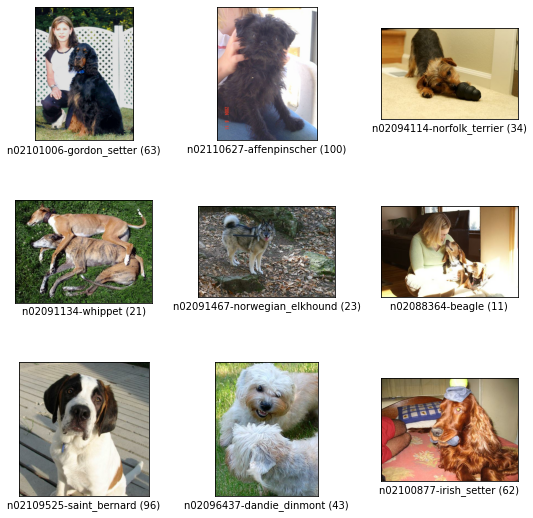

In [ ]:
fig = tfds.show_examples(train, info)

#2.2 Retrieve breed list

In [ ]:
breed_list = []

for filename in info.features['label'].names:
  separator = [i for i, letter in enumerate(filename) if letter == '-']
  breed_list.append(filename[separator[0]+1:])

print(breed_list)

['chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih-tzu', 'blenheim_spaniel', 'papillon', 'toy_terrier', 'rhodesian_ridgeback', 'afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'walker_hound', 'english_foxhound', 'redbone', 'borzoi', 'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound', 'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound', 'weimaraner', 'staffordshire_bullterrier', 'american_staffordshire_terrier', 'bedlington_terrier', 'border_terrier', 'kerry_blue_terrier', 'irish_terrier', 'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier', 'wire-haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier', 'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont', 'boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'scotch_terrier', 'tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'west_highland_white_terrier', 'lhasa', 'flat-coated_retriever', 'cur

##2.3 Visualise dataset distributions

In [ ]:
train_labels, train_counts = np.unique(np.fromiter(train.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

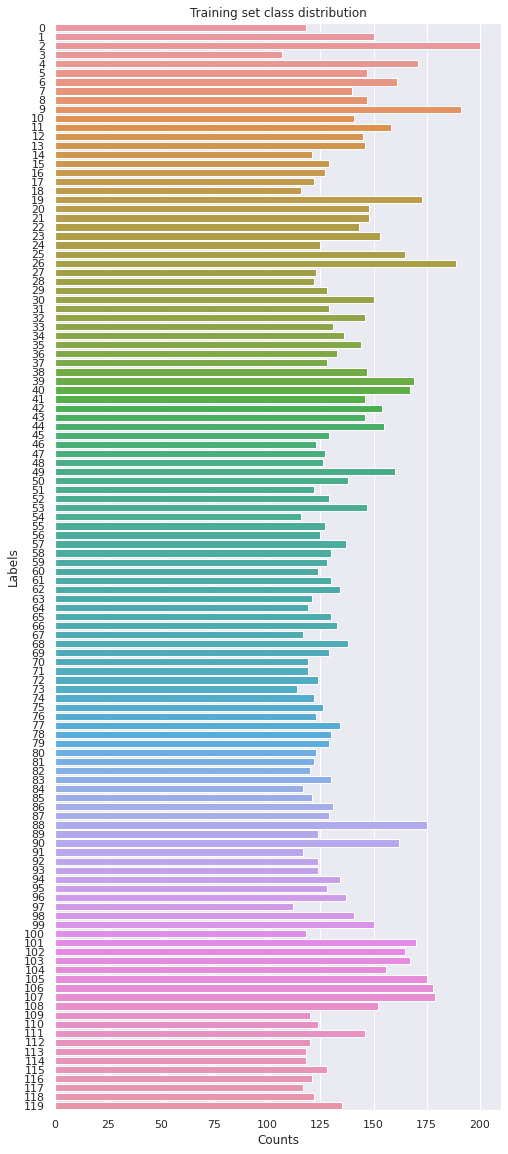

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Training set class distribution")
sns.barplot(x = train_counts, y = train_labels, orient='h') 

In [ ]:
val_labels, val_counts = np.unique(np.fromiter(val.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

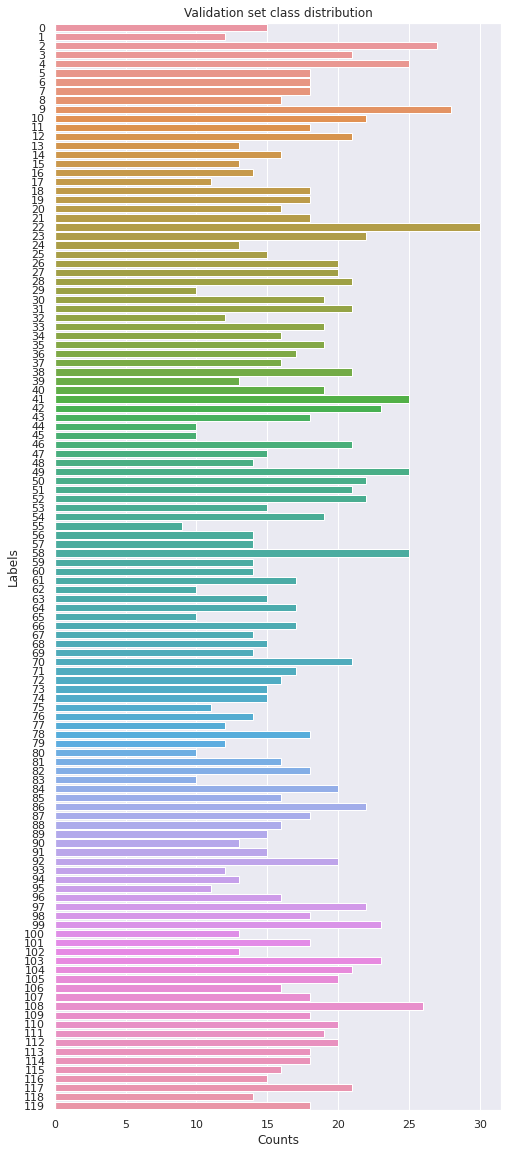

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = val_counts, y = val_labels, orient='h') 

In [ ]:
test_labels, test_counts = np.unique(np.fromiter(test.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

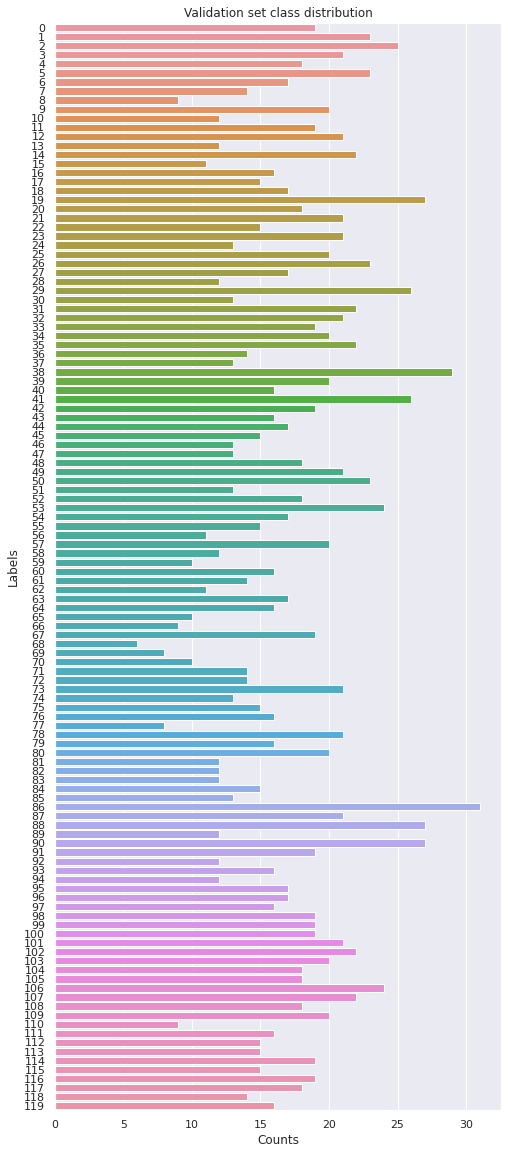

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = test_counts, y = test_labels, orient='h') 

#**3. Modelling**

##3.1 Preprocessing Layers

In [ ]:
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64
RANDOM_SEED = 43

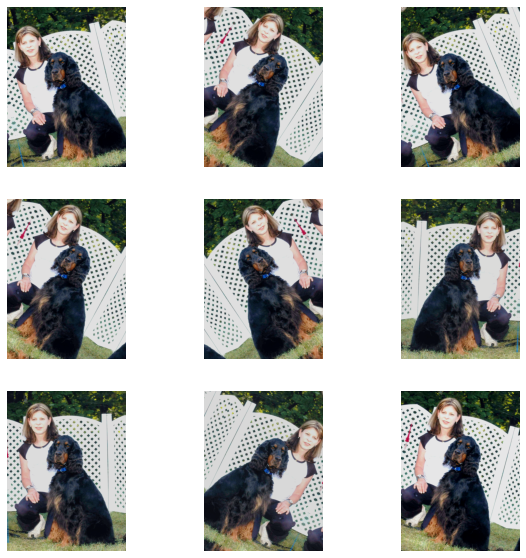

In [ ]:
img_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(factor=0.1),
                                        ])

# Visualize some augmentations
ex_img, label = next(iter(train))
ex_img = tf.cast(ex_img, tf.float32) / 255.

img_batch = tf.cast(tf.expand_dims(ex_img, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_img = img_augmentation(img_batch, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_img[0])
  plt.axis("off")

In [ ]:
# Efficientnet takes input images of shape (224, 224, 3) with range [0,255] --> normalisation not needed
# reference: https://keras.io/api/applications/efficientnet/#efficientnetb0-function

def one_hot(image, label):
  label = tf.one_hot(label,NUM_BREEDS)
  return image, label

def resize(image, label):
  image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
  return image, label

def preprocess(image, label):
  return tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(image, tf.float32)), label

# Resize and one-hot encode all datasets

ds_train = train.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


ds_val = val.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE, drop_remainder=True)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)


ds_test = test.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE, drop_remainder=True)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


##3.2 Feature Extraction

In [ ]:
def create_model():
  inputs = Input(shape=INPUT_SHAPE)
  x = img_augmentation(inputs)
  base = tf.keras.applications.MobileNetV2(input_tensor=x,
                                                input_shape=INPUT_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
  base.trainable = False
  x = GlobalAveragePooling2D()(base.output)
  x = layers.BatchNormalization()(x)
  x = Dense(1280, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(RANDOM_SEED), bias_initializer='zeros')(x)
  x = layers.BatchNormalization()(x)
  outputs = Dense(NUM_BREEDS, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

  return Model(inputs=inputs, outputs=outputs, name='MNV2')

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

model.summary()

Model: "MNV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['sequential[1][0]']             
                                )                                                              

In [ ]:
EPOCHS = 45
CP_PATH = CP_DIR+'FE/MNV2-{epoch:02d}.h5'

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)

cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(ds_train, 
                    epochs=EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

# save the model if results are satisfactory
model.save(CP_PATH+'/model/MNV2.h5')

Epoch 1/45
257/257 [==============================] - 24s 76ms/step - loss: 1.2610 - accuracy: 0.6575 - top_k_categorical_accuracy: 0.9050 - val_loss: 0.6610 - val_accuracy: 0.8066 - val_top_k_categorical_accuracy: 0.9775
Epoch 2/45
257/257 [==============================] - 17s 68ms/step - loss: 0.7254 - accuracy: 0.7814 - top_k_categorical_accuracy: 0.9692 - val_loss: 0.7068 - val_accuracy: 0.8003 - val_top_k_categorical_accuracy: 0.9756
Epoch 3/45
257/257 [==============================] - 18s 68ms/step - loss: 0.5888 - accuracy: 0.8173 - top_k_categorical_accuracy: 0.9804 - val_loss: 0.6707 - val_accuracy: 0.7983 - val_top_k_categorical_accuracy: 0.9775
Epoch 4/45
257/257 [==============================] - 19s 73ms/step - loss: 0.4851 - accuracy: 0.8455 - top_k_categorical_accuracy: 0.9865 - val_loss: 0.6860 - val_accuracy: 0.8071 - val_top_k_categorical_accuracy: 0.9717
Epoch 5/45
257/257 [==============================] - 18s 69ms/step - loss: 0.4377 - accuracy: 0.8573 - top_k_ca

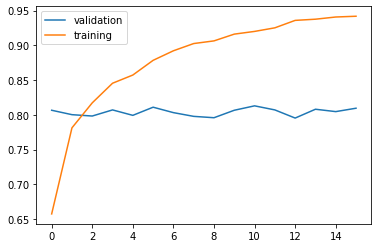

In [ ]:
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='training')
plt.legend()
plt.show()

In [ ]:
logname = CP_DIR + '/FE.csv'

df_history = pd.DataFrame.from_dict(history.history) 
df_history.to_csv (logname, index = False, header=True)

##3.3 Finetuning

In [ ]:
def print_trainable(model):
  for layer_id, layer in enumerate(model.layers):
    print(layer_id,' ' , layer.name, ": ", layer.trainable)

In [ ]:
# Load the best model
ft_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/MNV2/FE/MNV2-11.h5")

def unfreeze(model, start_layer, end_layer):
  for layer_id, layer in enumerate(model.layers):
    if layer_id >= start_layer and layer_id <= end_layer:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Unfreeze all layers
unfreeze(ft_model, 0, len(ft_model.layers)-1)

In [ ]:
print_trainable(ft_model)

0   input_1 :  True
1   sequential :  True
2   Conv1 :  True
3   bn_Conv1 :  False
4   Conv1_relu :  True
5   expanded_conv_depthwise :  True
6   expanded_conv_depthwise_BN :  False
7   expanded_conv_depthwise_relu :  True
8   expanded_conv_project :  True
9   expanded_conv_project_BN :  False
10   block_1_expand :  True
11   block_1_expand_BN :  False
12   block_1_expand_relu :  True
13   block_1_pad :  True
14   block_1_depthwise :  True
15   block_1_depthwise_BN :  False
16   block_1_depthwise_relu :  True
17   block_1_project :  True
18   block_1_project_BN :  False
19   block_2_expand :  True
20   block_2_expand_BN :  False
21   block_2_expand_relu :  True
22   block_2_depthwise :  True
23   block_2_depthwise_BN :  False
24   block_2_depthwise_relu :  True
25   block_2_project :  True
26   block_2_project_BN :  False
27   block_2_add :  True
28   block_3_expand :  True
29   block_3_expand_BN :  False
30   block_3_expand_relu :  True
31   block_3_pad :  True
32   block_3_depthwise 

In [ ]:
ft_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

ft_model.summary()

Model: "MNV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['sequential[0][0]']             
                                )                                                              

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)

CP_PATH = CP_DIR+'FT/MNV2-{epoch:02d}.h5'

cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

FT_EPOCHS = 30
ft_history = ft_model.fit(ds_train, 
                    epochs=FT_EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

Epoch 1/30
257/257 [==============================] - 100s 370ms/step - loss: 0.1646 - accuracy: 0.9445 - top_k_categorical_accuracy: 0.9984 - val_loss: 0.7588 - val_accuracy: 0.8159 - val_top_k_categorical_accuracy: 0.9722
Epoch 2/30
257/257 [==============================] - 91s 356ms/step - loss: 0.1198 - accuracy: 0.9616 - top_k_categorical_accuracy: 0.9994 - val_loss: 0.7380 - val_accuracy: 0.8164 - val_top_k_categorical_accuracy: 0.9731
Epoch 3/30
257/257 [==============================] - 93s 361ms/step - loss: 0.1064 - accuracy: 0.9682 - top_k_categorical_accuracy: 0.9994 - val_loss: 0.7426 - val_accuracy: 0.8140 - val_top_k_categorical_accuracy: 0.9731
Epoch 4/30
257/257 [==============================] - 93s 360ms/step - loss: 0.0914 - accuracy: 0.9715 - top_k_categorical_accuracy: 0.9996 - val_loss: 0.7355 - val_accuracy: 0.8184 - val_top_k_categorical_accuracy: 0.9731
Epoch 5/30
257/257 [==============================] - 92s 357ms/step - loss: 0.0905 - accuracy: 0.9721 - to

In [ ]:
logname = CP_DIR + '/FT.csv'

df_history = pd.DataFrame.from_dict(history.history) 
df_history.to_csv (logname, index = False, header=True)

## 3.4 Testing

In [ ]:
best_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/MNV2/FT/MNV2-06.h5')

In [ ]:
best_model.evaluate(ds_test)

32/32 [==============================] - 3s 48ms/step - loss: 0.7871 - accuracy: 0.7930 - top_k_categorical_accuracy: 0.9712


[0.7870870232582092, 0.79296875, 0.97119140625]